## Standard Imports

In [ ]:
# standard imports
import tensorflow as tf            # tensorflow importing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D,Conv1DTranspose,Concatenate,Input, PReLU
from tensorflow.keras.layers import BatchNormalization, Dense, Flatten, LeakyReLU, Reshape
import numpy as np                 # numpy package importing
import matplotlib.pyplot as plt    # matplotlib package importing
import os
import time
import datetime                   # to save checkpoints 
import IPython.display
import glob
from tqdm.notebook import tqdm     # a library used to visualize progress as a dynamic filling bar 
import librosa.display              # a python package used to do analysis on audio data and visualize it

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


## Loading the dataset 

In [ ]:
!mkdir "CleanData"
!mkdir "NoisyData"

mkdir: cannot create directory ‘CleanData’: File exists
mkdir: cannot create directory ‘NoisyData’: File exists


In [ ]:
!unzip "/content/drive/My Drive/ML works/SoC/clean_trainset_wav.zip" -d "CleanData"

Archive:  /content/drive/My Drive/ML works/SoC/clean_trainset_wav.zip
replace CleanData/p226_001.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N


In [ ]:
!unzip "/content/drive/My Drive/ML works/SoC/noisy_trainset_wav.zip" -d "NoisyData"

Streaming output truncated to the last 5000 lines.
  inflating: NoisyData/p267_421.wav  
  inflating: NoisyData/p268_001.wav  
  inflating: NoisyData/p268_002.wav  
  inflating: NoisyData/p268_003.wav  
  inflating: NoisyData/p268_004.wav  
  inflating: NoisyData/p268_005.wav  
  inflating: NoisyData/p268_006.wav  
  inflating: NoisyData/p268_007.wav  
  inflating: NoisyData/p268_009.wav  
  inflating: NoisyData/p268_010.wav  
  inflating: NoisyData/p268_011.wav  
  inflating: NoisyData/p268_012.wav  
  inflating: NoisyData/p268_013.wav  
  inflating: NoisyData/p268_014.wav  
  inflating: NoisyData/p268_015.wav  
  inflating: NoisyData/p268_016.wav  
  inflating: NoisyData/p268_017.wav  
  inflating: NoisyData/p268_018.wav  
  inflating: NoisyData/p268_019.wav  
  inflating: NoisyData/p268_020.wav  
  inflating: NoisyData/p268_021.wav  
  inflating: NoisyData/p268_022.wav  
  inflating: NoisyData/p268_024.wav  
  inflating: NoisyData/p268_025.wav  
  inflating: NoisyData/p268_026.wav  

In [ ]:
clean_sounds = glob.glob('/content/CleanData/*')
clean_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(clean_sounds[0]),desired_channels=1)
for i in tqdm(clean_sounds[1:]):
  so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
  clean_sounds_list = tf.concat((clean_sounds_list,so),0)

  0%|          | 0/11571 [00:00<?, ?it/s]

In [ ]:
noisy_sounds = glob.glob('/content/NoisyData/*')
noisy_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(noisy_sounds[0]),desired_channels=1)
for i in tqdm(noisy_sounds[1:]):
  so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
  noisy_sounds_list = tf.concat((noisy_sounds_list,so),0)

  0%|          | 0/11571 [00:00<?, ?it/s]

In [ ]:
print(len(clean_sounds_list),len(noisy_sounds_list))

540938091 540938091


In [ ]:
batching_size = 16384

clean_train,noisy_train = [],[]

for i in tqdm(range(0,clean_sounds_list.shape[0]-batching_size,batching_size)):
  clean_train.append(clean_sounds_list[i:i+batching_size])
  noisy_train.append(noisy_sounds_list[i:i+batching_size])

# clean_train_data = tf.stack(clean_train)
# noisy_train_data = tf.stack(noisy_train)

len(clean_train),len(noisy_train)

  0%|          | 0/33016 [00:00<?, ?it/s]

(33016, 33016)

In [ ]:
clean_sounds_list = []
noisy_sounds_list = []

In [ ]:
clean_train = tf.stack(clean_train)

In [ ]:
noisy_train = tf.stack(noisy_train)

In [ ]:
clean_train.shape, noisy_train.shape

(TensorShape([33016, 16384, 1]), TensorShape([33016, 16384, 1]))

## Building the models necessary for building GAN model

### Generator

- The model is built as described in the SEGAN paper which comprises of 22 1d convolution layers (both conv1D and conv1DTranspose) 
- Each conv1D layer is followed by a PReLU activtion layer

In [ ]:
inp = Input(shape=(16384,1))

# inp2 = Input(shape = (8,1024))

# c1 = Conv1D(16,32,2,'same',activation='relu')(inp)
# c2 = Conv1D(32,32,2,'same',activation='relu')(c1)
# c3 = Conv1D(32,32,2,'same',activation='relu')(c2)
# c4 = Conv1D(64,32,2,'same',activation='relu')(c3)
# c5 = Conv1D(64,32,2,'same',activation='relu')(c4)
# c6 = Conv1D(128,32,2,'same',activation='relu')(c5)
# c7 = Conv1D(128,32,2,'same',activation='relu')(c6)
# c8 = Conv1D(256,32,2,'same',activation='relu')(c7)
# c9 = Conv1D(256,32,2,'same',activation='relu')(c8)
# c10 = Conv1D(512,32,2,'same',activation='relu')(c9)
# c11 = Conv1D(1024,32,2,'same',activation='relu')(c10)

# encoder stage

c1 = Conv1D(16,32,2,'same')(inp)
c1 = PReLU()(c1)

c2 = Conv1D(32,32,2,'same')(c1)
c2 = PReLU()(c2)

c3 = Conv1D(32,32,2,'same')(c2)
c3 = PReLU()(c3)

c4 = Conv1D(64,32,2,'same')(c3)
c4 = PReLU()(c4)

c5 = Conv1D(64,32,2,'same')(c4)
c5 = PReLU()(c5)

c6 = Conv1D(128,32,2,'same')(c5)
c6 = PReLU()(c6)

c7 = Conv1D(128,32,2,'same')(c6)
c7 = PReLU()(c7)

c8 = Conv1D(256,32,2,'same')(c7)
c8 = PReLU()(c8)

c9 = Conv1D(256,32,2,'same')(c8)
c9 = PReLU()(c9)

c10 = Conv1D(512,32,2,'same')(c9)
c10 = PReLU()(c10)

c11 = Conv1D(1024,32,2,'same')(c10)
c11 = PReLU()(c11)
# zc = Concatenate()([c11,inp2])

# decoder stage

dc1 = Conv1DTranspose(1024,32,1,padding='same')(c11)
dc1 = PReLU()(dc1)
conc = Concatenate()([c11,dc1])

dc2 = Conv1DTranspose(512,32,2,padding='same')(conc)
dc2 = PReLU()(dc2)
conc = Concatenate()([c10,dc2])

dc3 = Conv1DTranspose(256,32,2,padding='same')(conc)
dc3 = PReLU()(dc3)
conc = Concatenate()([c9,dc3])

dc4 = Conv1DTranspose(256,32,2,padding='same')(conc)
dc4 = PReLU()(dc4)
conc = Concatenate()([c8,dc4])

dc5 = Conv1DTranspose(128,32,2,padding='same')(conc)
dc5 = PReLU()(dc5)
conc = Concatenate()([c7,dc5])

dc6 = Conv1DTranspose(128,32,2,padding='same')(conc)
dc6 = PReLU()(dc6)
conc = Concatenate()([c6,dc6])

dc7 = Conv1DTranspose(64,32,2,padding='same')(conc)
dc7 = PReLU()(dc7)
conc = Concatenate()([c5,dc7])

dc8 = Conv1DTranspose(64,32,2,padding='same')(conc)
dc8 = PReLU()(dc8)
conc = Concatenate()([c4,dc8])

dc9 = Conv1DTranspose(32,32,2,padding='same')(conc)
dc9 = PReLU()(dc9)
conc = Concatenate()([c3,dc9])

dc10 = Conv1DTranspose(32,32,2,padding='same')(conc)
dc10 = PReLU()(dc10)
conc = Concatenate()([c2,dc10])

dc11 = Conv1DTranspose(16,32,2,padding='same')(conc)
dc11 = PReLU()(dc11)
conc = Concatenate()([c1,dc11])

dc12 = Conv1DTranspose(1,32,2,padding='same')(conc)
# dc12 = PReLU()(dc12)
conc = Concatenate()([inp,dc12])

dc13 = Conv1DTranspose(1,32,1,padding='same',activation='linear')(conc)

generator = tf.keras.models.Model(inp,dc13)

In [ ]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16384, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 8192, 16)     528         ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 8192, 16)     131072      ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 4096, 32)     16416       ['p_re_lu[0][0]']                
                                                                                              

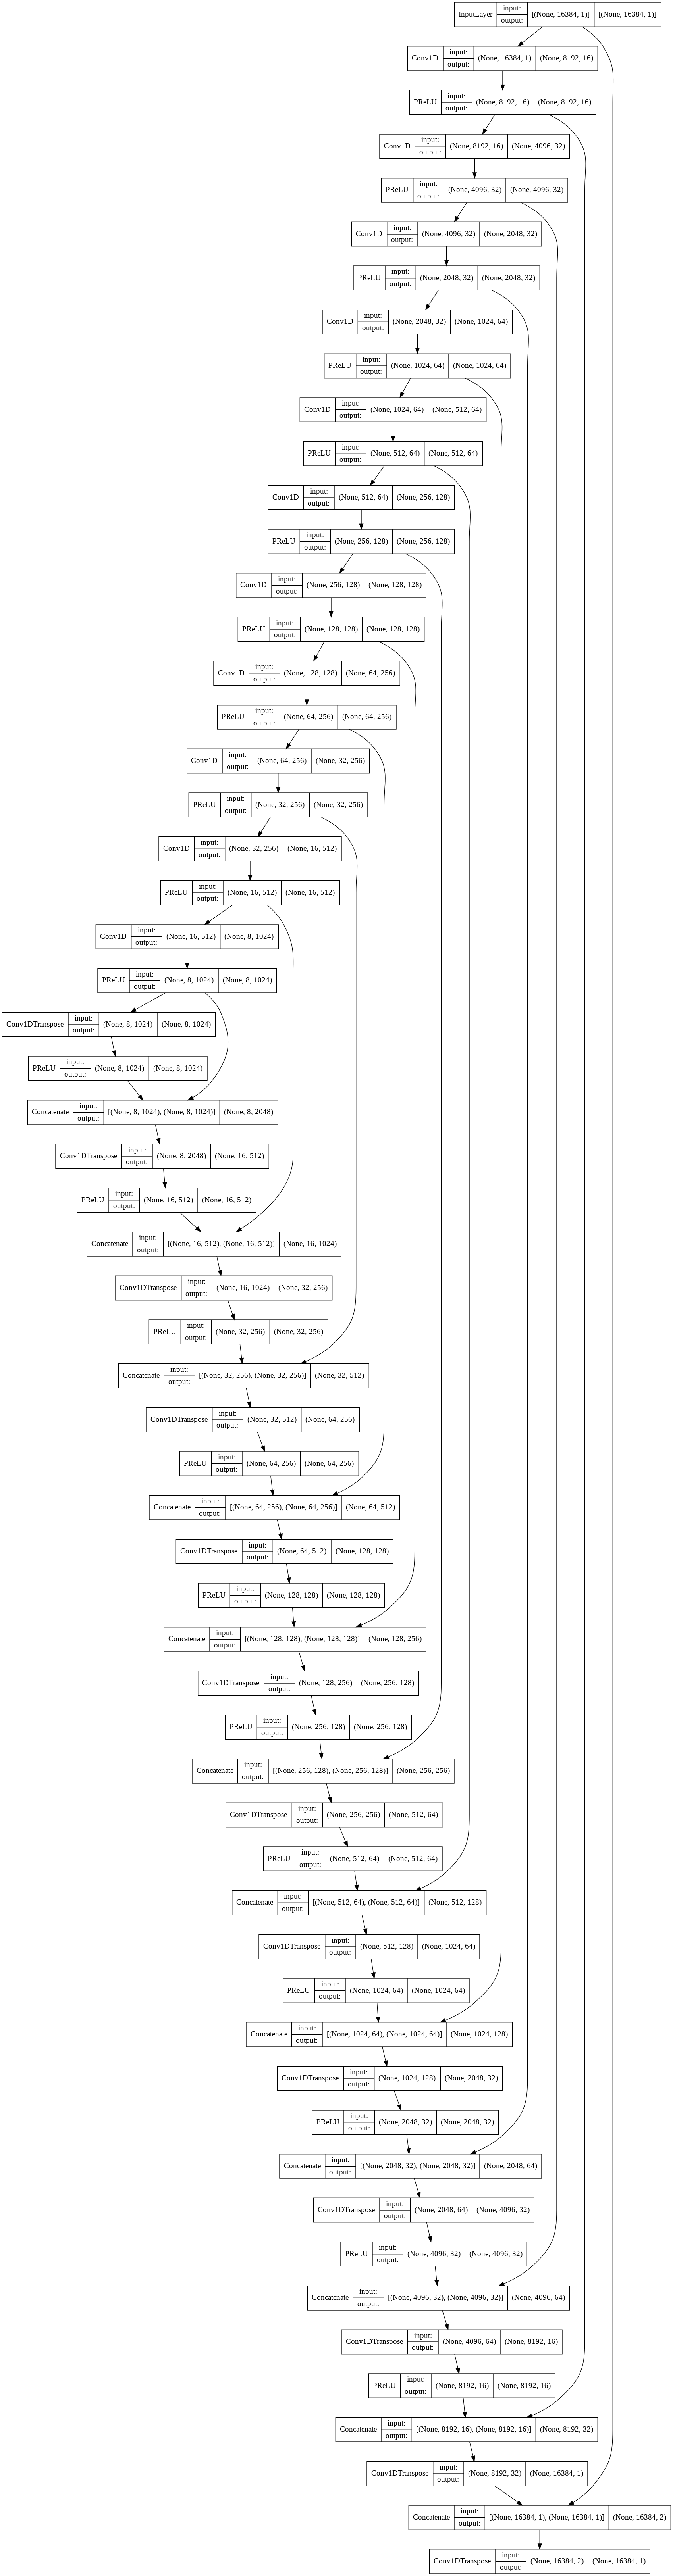

In [ ]:
tf.keras.utils.plot_model(generator,show_shapes=True,show_layer_names=False)

### Discriminator

In [ ]:
# inp = (16384,2)
# discriminator = Sequential([
#                   Conv1D(16,32,2,'same', input_shape = inp),
#                   LeakyReLU(alpha=0.3),

#                   Conv1D(32,32,2,'same'),
#                   LeakyReLU(alpha=0.3),
                  
#                   Conv1D(32,32,2,'same'),
#                   LeakyReLU(alpha=0.3),
                  
#                   Conv1D(64,32,2,'same'),
#                   LeakyReLU(alpha=0.3),
                  
#                   Conv1D(64,32,2,'same'),
#                   LeakyReLU(alpha=0.3),
                  
#                   Conv1D(128,32,2,'same'),
#                   LeakyReLU(alpha=0.3),
                  
#                   Conv1D(128,32,2,'same'),
#                   LeakyReLU(alpha=0.3),
                  
#                   Conv1D(256,32,2,'same'),
#                   LeakyReLU(alpha=0.3),
                  
#                   Conv1D(256,32,2,'same'),
#                   LeakyReLU(alpha=0.3),
                  
#                   Conv1D(512,32,2,'same'),
#                   LeakyReLU(alpha=0.3),
                  
#                   Conv1D(1024,32,2,'same'),
#                   LeakyReLU(alpha=0.3),

#                   Conv1D(1,32,1,'same'),
#                   LeakyReLU(alpha=0.3),

#                   Dense(1, activation=None),  
# ])

inp1 = Input(shape=(16384,1))
inp2 = Input(shape = (16384,1))

c00 = Concatenate()([inp1, inp2]) 
c01 = Conv1DTranspose(1,32,1,padding='same')(c00)

c1 = Conv1D(16,32,2,'same')(c01)
c1 = LeakyReLU(alpha=0.3)(c1)

c2 = Conv1D(32,32,2,'same')(c1)
c2 = LeakyReLU(alpha=0.3)(c2)

c3 = Conv1D(32,32,2,'same')(c2)
c3 = LeakyReLU(alpha=0.3)(c3)

c4 = Conv1D(64,32,2,'same')(c3)
c4 = LeakyReLU(alpha=0.3)(c4)

c5 = Conv1D(64,32,2,'same')(c4)
c5 = LeakyReLU(alpha=0.3)(c5)

c6 = Conv1D(128,32,2,'same')(c5)
c6 = LeakyReLU(alpha=0.3)(c6)

c7 = Conv1D(128,32,2,'same')(c6)
c7 = LeakyReLU(alpha=0.3)(c7)

c8 = Conv1D(256,32,2,'same')(c7)
c8 = LeakyReLU(alpha=0.3)(c8)

c9 = Conv1D(256,32,2,'same')(c8)
c9 = LeakyReLU(alpha=0.3)(c9)

c10 = Conv1D(512,32,2,'same')(c9)
c10 = LeakyReLU(alpha=0.3)(c10)

c11 = Conv1D(1024,32,2,'same')(c10)
c11 = LeakyReLU(alpha=0.3)(c11)

c12 = Conv1D(1, 32, 1, 'same')(c11)
c12 = LeakyReLU(alpha=0.3)(c12)

f = Flatten()(c12)

dense1 = Dense(1, activation=None)(f)

discriminator = tf.keras.models.Model([inp1, inp2],dense1)

# discriminatormodel.add(Dense(1, activation=None))

In [ ]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 16384, 1)]   0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 16384, 1)]   0           []                               
                                                                                                  
 concatenate_12 (Concatenate)   (None, 16384, 2)     0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 conv1d_transpose_13 (Conv1DTra  (None, 16384, 1)    65          ['concatenate_12[0][0]']   

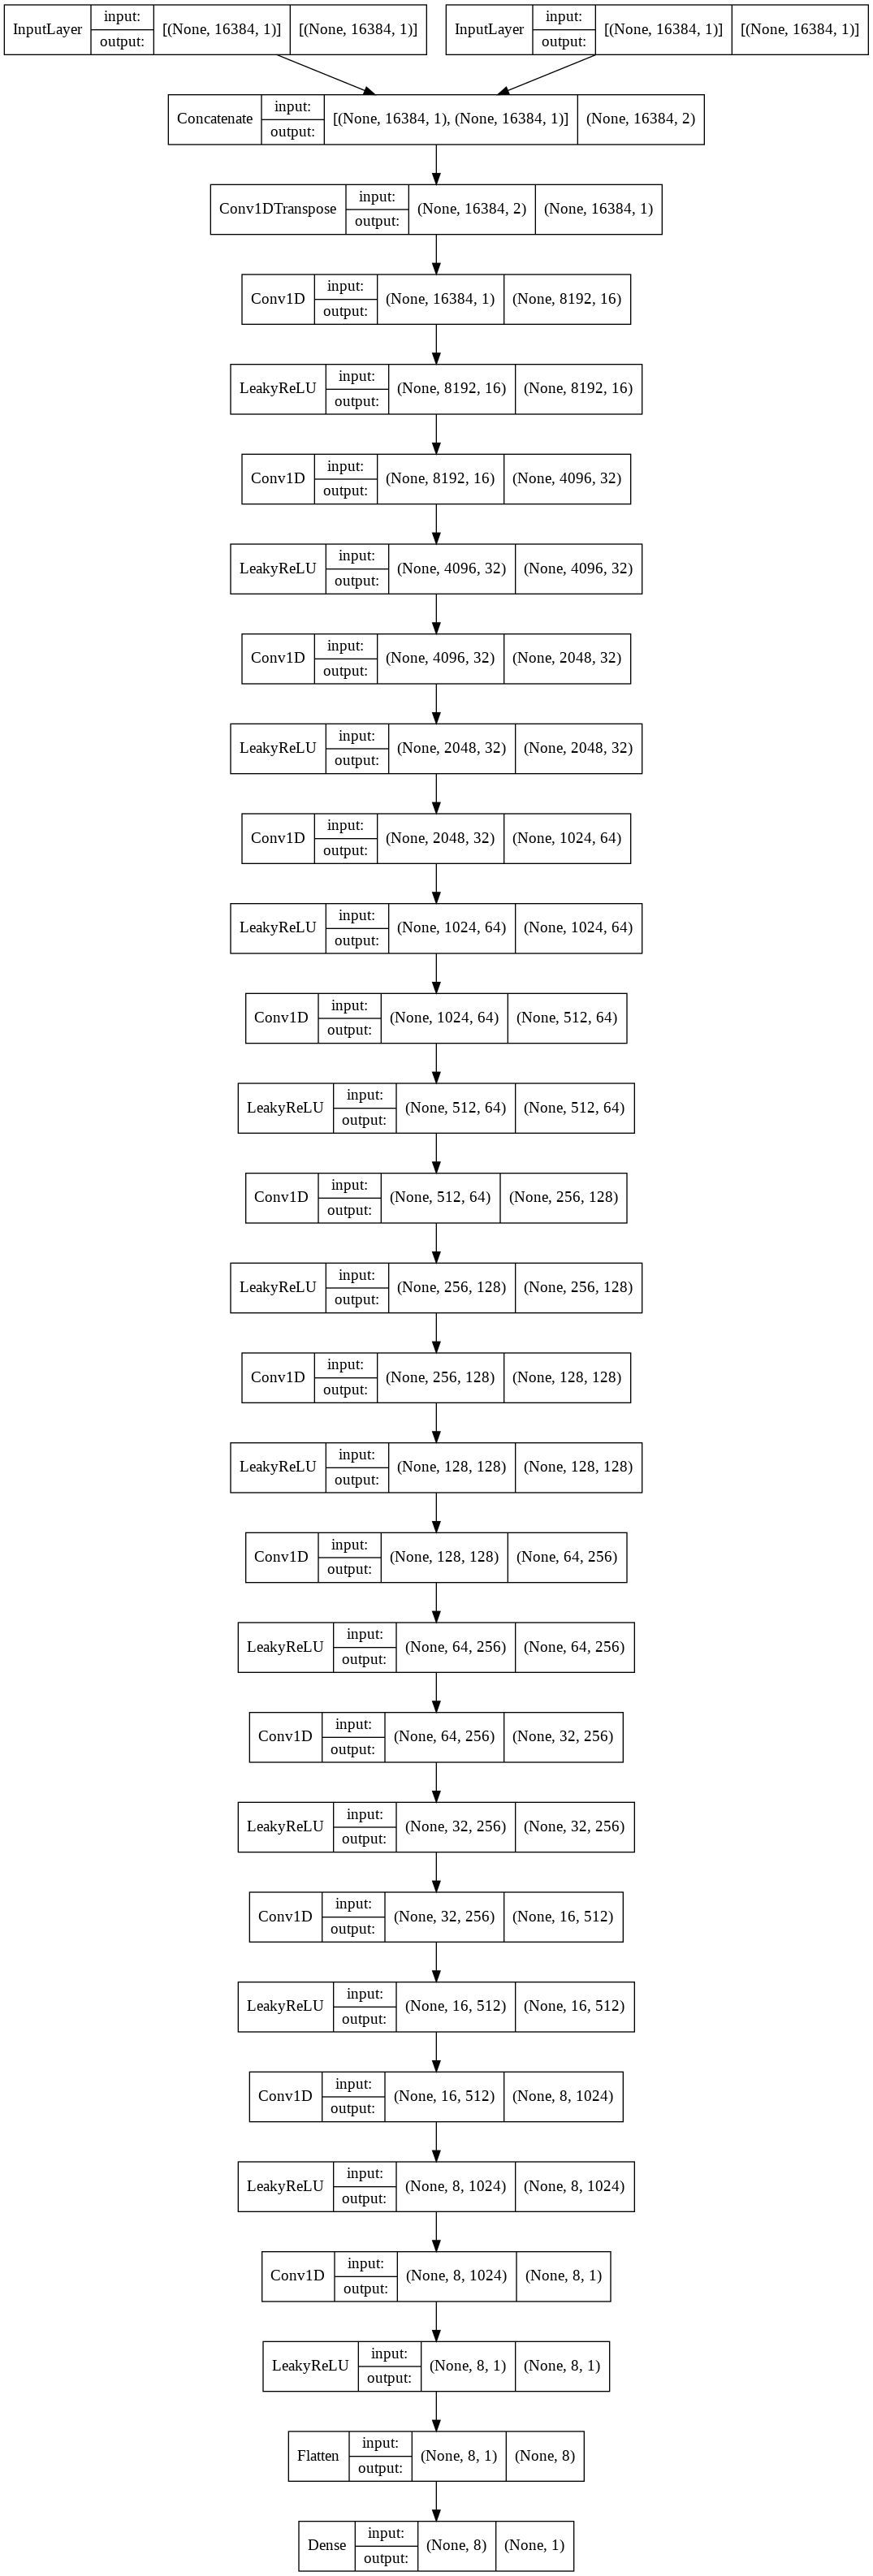

In [ ]:
tf.keras.utils.plot_model(discriminator,show_shapes=True,show_layer_names=False)

## Defining the GAN model
- We make a function that returns the combined GAN model
- We make it by combining the previously built discriminator and generator model sequentially
- We make the *parameters of discriminator* model *non-trainable*
- We will train the discriminator model's parameters seperately via a manually written $for$ loop 

In [ ]:
# # function that returns the GAN model by combining the generator and discriminator models given as input
# def gan_model(g_model, d_model):
#   d_model.trainable = False
#   gen_audio, gen_z = g_model.input
#   gen_output = g_model.output
#   conc = Concatenate()([gen_audio,gen_output])
#   gan_output = d_model(conc)
#   model = tf.keras.models.Model([gen_audio, gen_z], gan_output)
#   # model.compile(loss = 'binary_crossentropy', optimizer = 'adam')
#   return model

In [ ]:
# ganmodel = gan_model(generator, discriminator)

In [ ]:
# tf.keras.utils.plot_model(ganmodel,show_shapes=True,show_layer_names=False)

## Training the GAN model
- A function that trains the GAN model
- It will train the GAN model by training the discriminator and then it will train the generator based on the results of the discriminator's classification

## Various utility functions

In [ ]:
## function to load true data i.e, the data which the discriminator classifies as 1
def generaterealsamples(noisydatatensors, cleandatatensors, noofsamples, shape):
  indexes = np.random.randint(0, shape, noofsamples)
  ndt = noisydatatensors[indexes]
  cdt = cleandatatensors[indexes]
  returnset = np.concatenate(ndt, cdt, axis = 2)
  y = np.ones((noofsamples, 1))
  return returnset, y

In [ ]:
## function to generate z
def generatez(noofsamples):
  mean = np.zeros(8*1024)
  cov = np.identity(8*1024)
  samples = np.random.multivariate_normal(mean, cov, noofsamples)
  samples = samples.reshape(noofsamples, 8, 1024)
  return samples

In [ ]:
## function to load fake data i.e, the data which the discriminator classifies as 0
def generatefakedata(g_model, noofsamples, ndt, cdt):
  z = generatez(noofsamples)
  predicted = g_model.predict([ndt,z])
  returnset = np.concatenate(ndt, predicted, axis = 2)
  y = np.zeros((noofsamples, 1))
  return returnset, y

In [ ]:
# data to divide it as batches of 64
def get_dataset(x_train,y_train):
  dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
  dataset = dataset.shuffle(100).batch(32,drop_remainder=True)
  return dataset

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
LAMBDA = 100  ## the L1 loss's parameter
epochs = 15  ## no of epochs to train the model

In [ ]:
# g_model is the generator we are using, ntd is the noisy tensor dataset, ctd is clean tensor dataset

def generated_audio(model,test_input,tar):
    prediction = model(test_input,training = True)
    mse = 0
    for i in range(prediction.shape[0]):
      mse = mse + tf.reduce_mean(tf.abs(tar[i] - prediction[i]))
    mse = mse/prediction.shape[0]
    return mse

In [ ]:
# function that generates and returns some of the losses i.e, the L1 loss, generator loss and the gan loss

def gen_loss(disc_generated_output,gen_output,target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA*l1_loss)
    # print("In general losses calculating function")
    return total_gen_loss,gan_loss,l1_loss

In [ ]:
# function that generates and returns the discriminator loss

def  discriminator_loss(disc_real_output,disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    toal_disc_loss = real_loss + generated_loss
    # print("In discriminator loss calculating function")
    return toal_disc_loss

## Training the Model

Since generator and discriminator are trained differently, we need different optimisers for both of them

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

Splitting the noisy dataset into train and test dataset 

In [ ]:
train_dataset = get_dataset(noisy_train[:30000],clean_train[:30000])
test_dataset = get_dataset(noisy_train[30000:],clean_train[30000:])
clean_test_dataset = clean_train[30000:]
noisy_test_dataset = noisy_train[30000:]

In [ ]:
noisy_train = []
clean_train = []

In [ ]:
type(noisy_train)

list

In [ ]:
len(train_dataset)

937

In [ ]:
#tf.shape(traindataset)
for elem in train_dataset:
  print(type(elem[0]))
  print(len(elem), len(elem[0]))
  print(tf.shape(elem[0]))
  break

<class 'tensorflow.python.framework.ops.EagerTensor'>
2 32
tf.Tensor([   32 16384     1], shape=(3,), dtype=int32)


Saving checkpoints

In [ ]:
checkpoint_dirs = './SEGAN_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dirs,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer, discriminator_optimizer = discriminator_optimizer, generator = generator, discriminator = discriminator)

In [ ]:
log_dir = "SEGAN_logs"
summary_writer = tf.summary.create_file_writer(log_dir + 'fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

#### Function that contributes major work of the training

In [ ]:
@tf.function    ## this annotation causes the function to be compiled
def train_step(input_audio, target, epoch):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        gen_output = generator(input_audio, training = True)

        disc_real_output = discriminator([input_audio,target], training = True)
        disc_generated_output = discriminator([input_audio,gen_output], training = True)

        # print("disc outputs done, going to calculate losses")

        gen_total_loss, gen_gan_loss, gen_l1_loss = gen_loss(disc_generated_output,gen_output,target)

        disc_loss = discriminator_loss(disc_real_output,disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
    discriminator_optimizer.apply_gradients((zip(discriminator_gradients,discriminator.trainable_variables)))

    with summary_writer.as_default():

        tf.summary.scalar('gen_total_loss',gen_total_loss, epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss,step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

    # print("finished")


#### Function for training the model

In [ ]:
meansqerr = generated_audio(generator, noisy_test_dataset, clean_test_dataset ) 
print(meansqerr)

KeyboardInterrupt: ignored

In [ ]:
# function to train the GAN model 

def fit(epochs,test_ds):

    for epoch in range(epochs):

        start = time.time()
        print("Initialised MSE to 0, going to calculate MSE now")
        mse = 0
        for example_input, example_target in test_ds.take(64):
            mse = mse + generated_audio(generator,example_input, example_target)

        print("Epoch {} mse {}".format(epoch, mse/78))
        
        for n, (input_audio,target) in train_dataset.enumerate():
            if (n+1)%100 == 0:
                print(n)
            train_step(input_audio, target,epoch)
        print()

        if (epoch + 1)%5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print("Time taken for epoch {} is {} sec \n".format(epoch+1, time.time()-start))

    checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
fit(epochs, test_dataset)

Initialised MSE to 0, going to calculate MSE now
Epoch 0 mse 0.012182028964161873
tf.Tensor(99, shape=(), dtype=int64)
tf.Tensor(199, shape=(), dtype=int64)
tf.Tensor(299, shape=(), dtype=int64)
tf.Tensor(399, shape=(), dtype=int64)
tf.Tensor(499, shape=(), dtype=int64)
tf.Tensor(599, shape=(), dtype=int64)
tf.Tensor(699, shape=(), dtype=int64)
tf.Tensor(799, shape=(), dtype=int64)
tf.Tensor(899, shape=(), dtype=int64)

Time taken for epoch 1 is 672.2664771080017 sec 

Initialised MSE to 0, going to calculate MSE now
Epoch 1 mse 0.01105781551450491
tf.Tensor(99, shape=(), dtype=int64)
tf.Tensor(199, shape=(), dtype=int64)
tf.Tensor(299, shape=(), dtype=int64)
tf.Tensor(399, shape=(), dtype=int64)
tf.Tensor(499, shape=(), dtype=int64)
tf.Tensor(599, shape=(), dtype=int64)
tf.Tensor(699, shape=(), dtype=int64)
tf.Tensor(799, shape=(), dtype=int64)
tf.Tensor(899, shape=(), dtype=int64)

Time taken for epoch 2 is 672.629994392395 sec 

Initialised MSE to 0, going to calculate MSE now
Epoch

In [ ]:
!mkdir -p saved_model
generator.save('saved_model/my_model')

NameError: ignored